# Stamp Search Engine

From a picture of a stamp, try and find the closest image in Weaviate.

In [1]:
import os
import cv2
import ipyplot
import weaviate

In [2]:
DATA_DIR = "data/stamps"
TEST_DIR = "data/test"
IMAGE_DIM = (100, 100)

In [3]:
def clean_image(image_path: str):
    """Clean image imported by user:
    - find largest contour and crop image to it
    - resize to same size as images in train sample
    - TODO: find image orientation?
    """
    img = cv2.imread(image_path)
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # find largest contour
    cnt = max(contours, key=cv2.contourArea)
    # crop image based on the largest contour
    x, y, w, h = cv2.boundingRect(cnt)
    cropped_contour = img[y:y+h, x:x+w]
    # resize (same size as train data)
    resized = cv2.resize(cropped_contour, IMAGE_DIM, interpolation= cv2.INTER_LINEAR)
    return img, resized

In [4]:
def search(client, test_image_path: str):
    nearImage = {
        "image": test_image_path,
    }
    res = client.query.get(
        "Stamp", ["path", "_additional { certainty }"]
    ).with_near_image(
        nearImage, encode=True
    ).with_limit(3).do()
    return res["data"]["Get"]["Stamp"]

In [5]:
!ls data/test

photo_2022-04-28_18-08-02.jpg	   photo_2022-04-29_16-01-11_4.jpg
photo_2022-04-28_18-08-02_v2.jpg   photo_2022-04-29_16-01-11_5_2.jpg
photo_2022-04-28_19-44-42_2.jpg    photo_2022-04-29_16-01-11_5.jpg
photo_2022-04-28_19-44-42_3.jpg    photo_2022-04-29_16-01-11_6.jpg
photo_2022-04-28_19-44-42_4.jpg    photo_2022-04-29_16-01-11_7.jpg
photo_2022-04-28_19-44-42.jpg	   photo_2022-04-29_16-01-11_8.jpg
photo_2022-04-28_19-47-58.jpg	   photo_2022-04-29_16-01-11.jpg
photo_2022-04-28_19-48-03.jpg	   photo_2022-04-29_16-01-12_2.jpg
photo_2022-04-29_16-01-11_2_2.jpg  photo_2022-04-29_16-01-12_3.jpg
photo_2022-04-29_16-01-11_2.jpg    photo_2022-04-29_16-01-12_4.jpg
photo_2022-04-29_16-01-11_3.jpg    photo_2022-04-29_16-01-12.jpg


/home/estelle/Documents/Code/weaviate/venv/lib/python3.8/site-packages/ipyplot/_utils.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(seq)



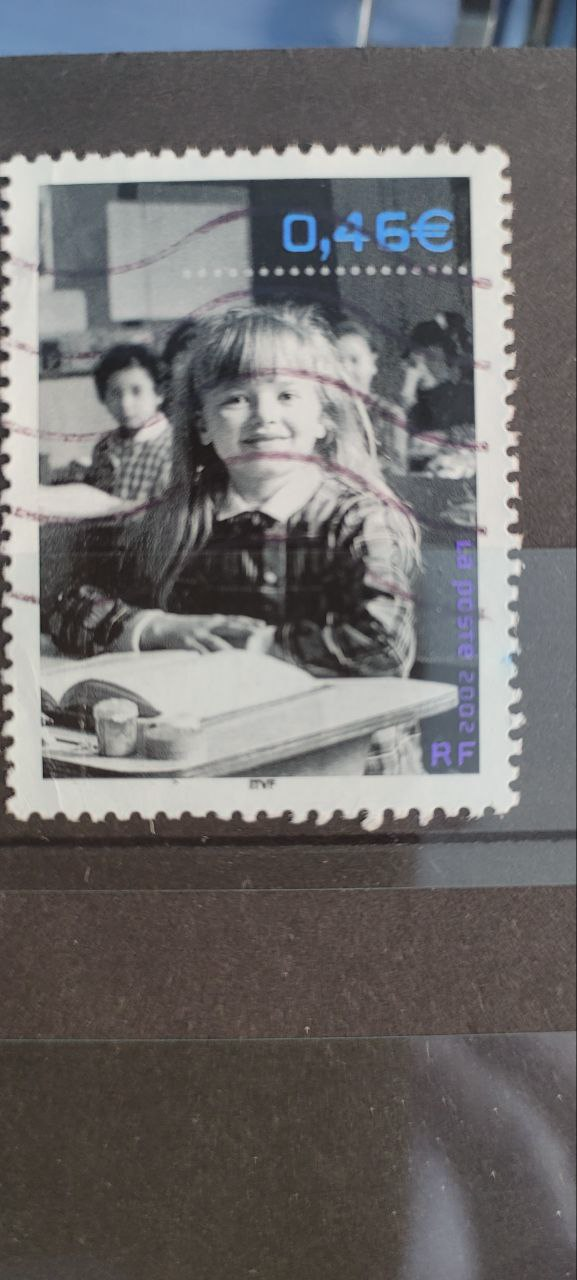
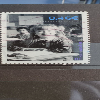


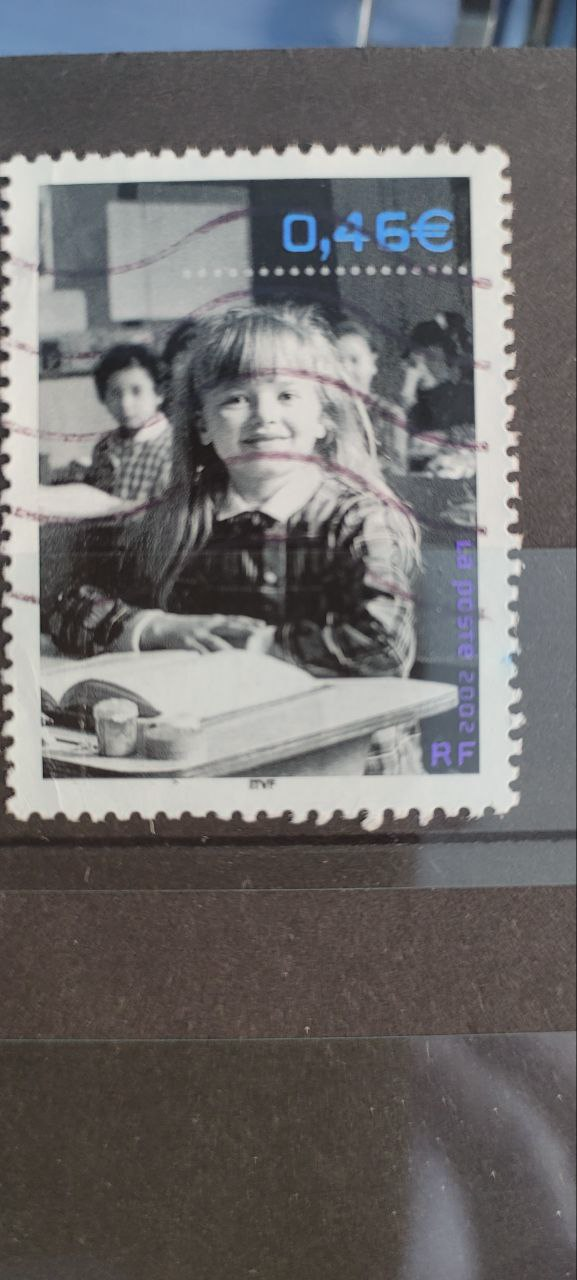
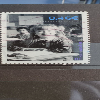

In [6]:
test_image = os.path.join(TEST_DIR, "photo_2022-04-28_18-08-02.jpg")

# clean image
img, prepared = clean_image(test_image)

# visualize input and prepared image
ipyplot.plot_images([img, prepared], custom_texts=["Initial", "Cleaned"])

In [7]:
test_image_prepared = "test_image.jpg"
cv2.imwrite(test_image_prepared, prepared)

True

In [8]:
client = weaviate.Client("http://localhost:8080")
res = search(client, test_image_prepared)


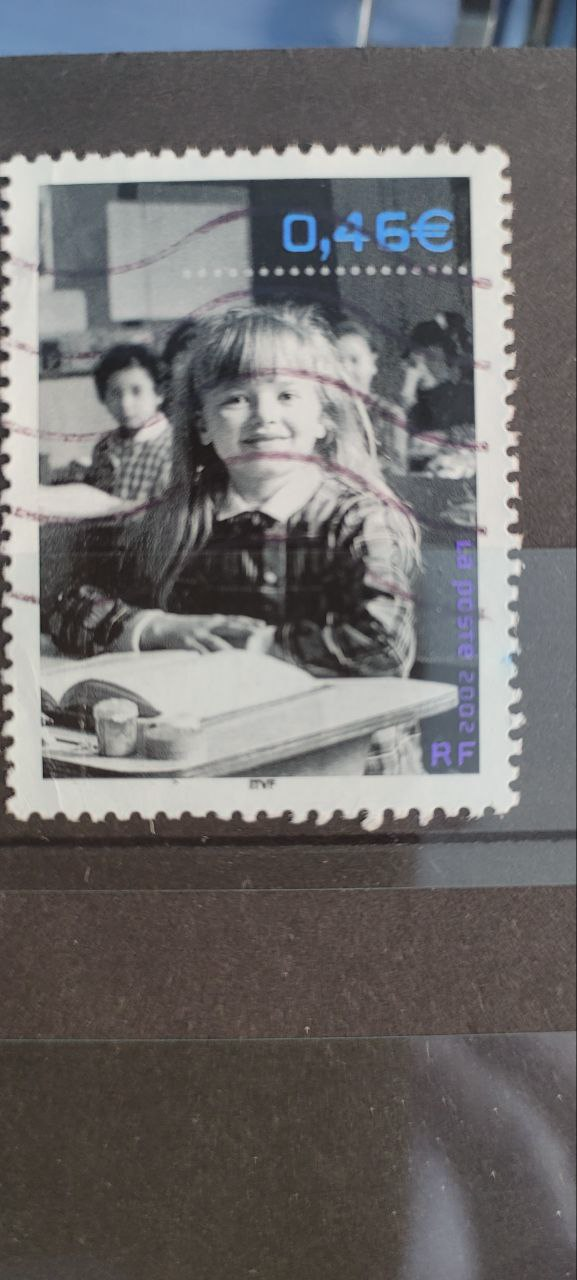
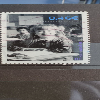


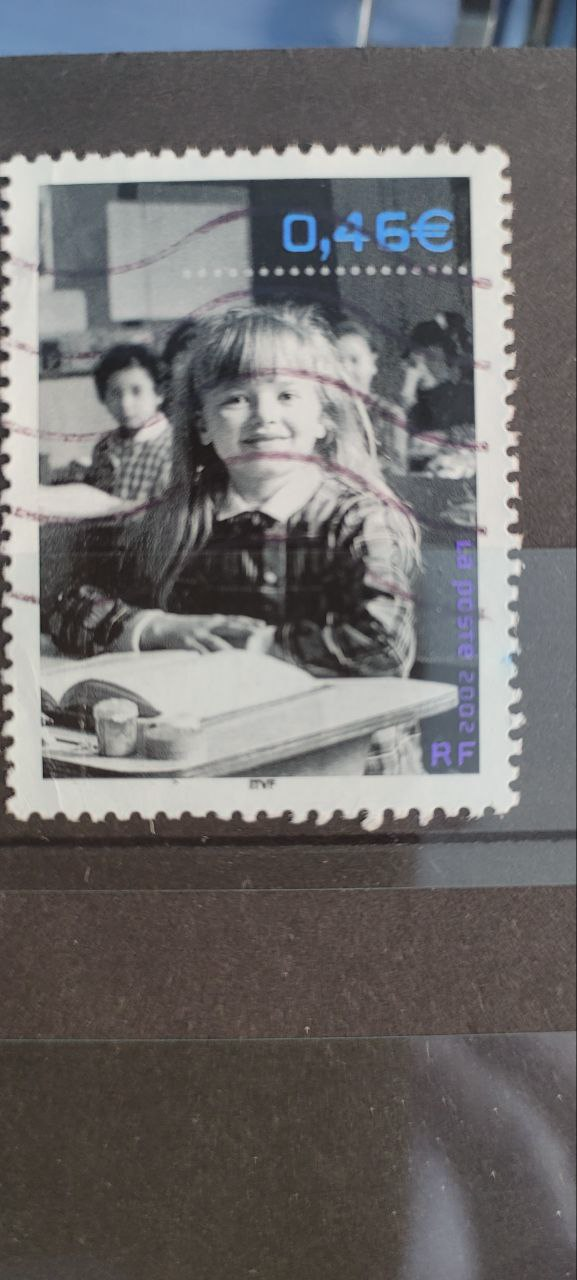
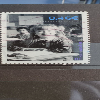

In [9]:
image_list = [img, prepared] + [
    os.path.join(DATA_DIR, fn["path"]) for fn in res
]
texts = ["Initial", "Cleaned"] + [
    "{}: {:2.3f}".format(k, r["_additional"]["certainty"]) for k, r in enumerate(res)
]

ipyplot.plot_images(image_list, show_url=False, custom_texts=texts)